In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 16, 'lines.markersize': 8})
cmap = get_cmap('tab10').colors


In [11]:
def loadhist(reduced_filename):
    '''
    Load histogram data from file at path 'data/<reduced_filename>_hist'
    Returns two arrays:
    - bins: the rightmost bin edges excluding the last bin
    - counts: the counts in each bin
    '''
    filename = 'data/' + reduced_filename + '_hist'
    conv = lambda s: float(s.decode().replace(',','.')) # Converter function for np.loadtxt
    data = np.loadtxt(filename, delimiter=";", converters=conv)
    return data[:,0], data[:,1]

## Channel-Energy-Calibration wirh Na22

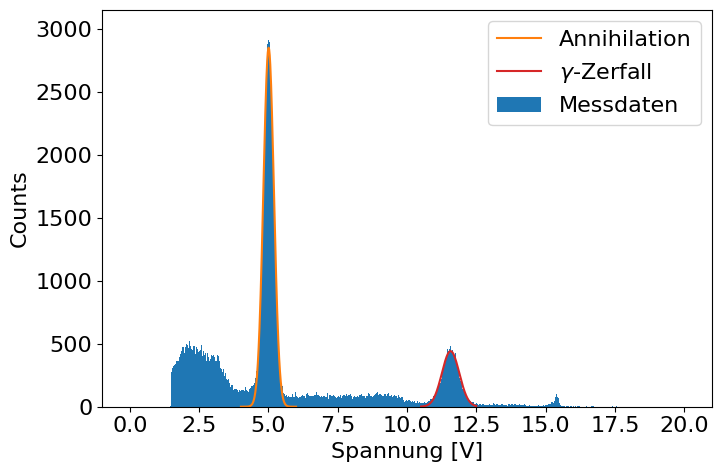

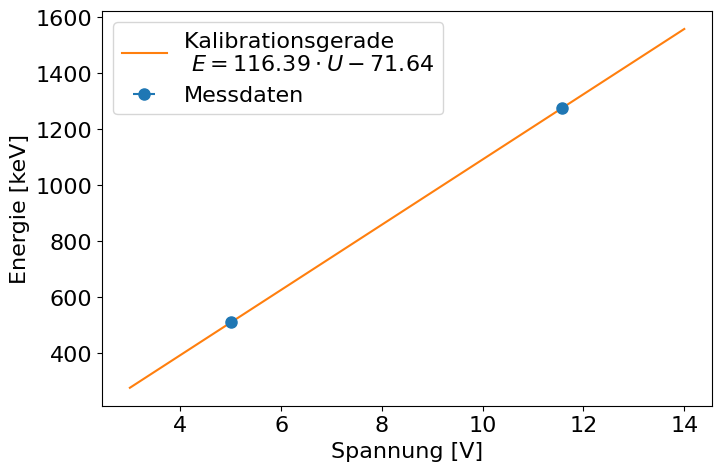

In [12]:
# Calibration behind the scenes -> func calibrate() and plots
def gauss(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))
b, c = loadhist('1_3_Na')
width = 0.01 # The width of each bin in the histogram
m_511 = (b>4) & (b<6)
m_1275 = (b>10.5) & (b<12.5)
popt_511, pcov_511 = curve_fit(gauss, b[m_511], c[m_511], p0=[1e3, 1, 1])
popt_1275, pcov_1275 = curve_fit(gauss, b[m_1275], c[m_1275], p0=[1e2, 10, 1])
mus = np.array([popt_511[1], popt_1275[1]])
err_mus = np.array([np.sqrt(pcov_511[1,1]), np.sqrt(pcov_1275[1,1])])
cal_slope = (1275-511)/(mus[1]-mus[0])
cal_intersect = 511 - cal_slope*mus[0]
def calibrate(x, m=cal_slope, t=cal_intersect):
    return m*x + t

fig,ax=plt.subplots(figsize=(7.5,5))
ax.bar(b,c, width=width, color=cmap[0], label='Messdaten')
ax.plot(b[m_511], gauss(b[m_511], *popt_511),color=cmap[1], label='Annihilation')
ax.plot(b[m_1275], gauss(b[m_1275], *popt_1275),color=cmap[3], label='$\gamma$-Zerfall')
ax.set(xlabel='Spannung [V]', ylabel='Counts')
ax.legend()
fig.tight_layout()

fig,ax=plt.subplots(figsize=(7.5,5))
ax.errorbar(mus, [511,1275], None, err_mus, 'o', label='Messdaten')
x = np.linspace(3,14,2)
ax.plot(x, calibrate(x), label=f'Kalibrationsgerade \n $E = {cal_slope :.2f} \cdot U {cal_intersect :.2f}$')
ax.set(xlabel='Spannung [V]', ylabel='Energie [keV]')
ax.legend()
fig.tight_layout()

## Energy Resolution

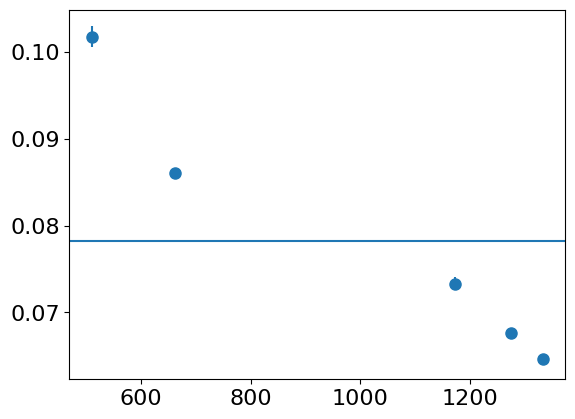

In [55]:
# Bins are the same for all three histograms
bins, c_na = loadhist('1_3_Na')
_ , c_cs = loadhist('1_3_Cs')
_ , c_co = loadhist('1_3_Co')
bins = calibrate(bins) # Do channel-energy-calibration on the bins
width = calibrate(0.01, cal_slope , 0) # And width

#Na22. Format: [[a1, mu1, sigma1], [std(a1), std(mu1), std(sigma1)], 
#               [a2, mu2, sigma2], [std(a2), std(mu2), std(sigma2)]]
na22 = []
m1 = (bins>300) & (bins<700)
m2 = (bins>1100) & (bins<1500)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_na[m1], p0=[1e3, 511, 1])
popt2, pcov2 = curve_fit(gauss, bins[m2], c_na[m2], p0=[1e3, 1275, 1])
na22.append([popt1, np.diag(pcov1)**0.5, popt2, np.diag(pcov2)**0.5])
na22 = np.array(na22).squeeze()

#Cs137:
cs137 = []
m1 = (bins>500) & (bins<1000)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_cs[m1], p0=[1e3, 511, 1])
cs137.append([popt1, np.diag(pcov1)**0.5])
cs137 = np.array(cs137).squeeze()

#Co60:
co60 = []
m1 = (bins>1050) & (bins<1190)
m2 = (bins>1200) & (bins<1500)
popt1, pcov1 = curve_fit(gauss, bins[m1], c_co[m1], p0=[500, 1e3, 100])
popt2, pcov2 = curve_fit(gauss, bins[m2], c_co[m2], p0=[500, 1200, 100])
co60.append([popt1, np.diag(pcov1)**0.5, popt2, np.diag(pcov2)**0.5])
co60 = np.array(co60).squeeze()
# plt.bar(bins, c_co, width=width, color=cmap[0], label='Messdaten')
# plt.plot(bins[m1], gauss(bins[m1], *co60[0]), color=cmap[1], label='Annihilation')
# plt.plot(bins[m2], gauss(bins[m2], *co60[2]), color=cmap[3], label='$\gamma$-Zerfall')

# Calc resolution:
fwhm = lambda sigma: 2*np.sqrt(2*np.log(2))*sigma
res_na22 = [fwhm(na22[0,2])/na22[0,1], fwhm(na22[2,2])/na22[2,1]]
res_cs137 = fwhm(cs137[0,2])/cs137[0,1]
res_co60 = [fwhm(co60[0,2])/co60[0,1], fwhm(co60[2,2])/co60[2,1]]
res = np.abs(np.array([*res_na22, res_cs137, *res_co60]))
def err_on_res(mu, sigma, errmu, errsigma):
    return np.sqrt((fwhm(errsigma)/mu)**2 + (fwhm(sigma)*errmu/mu**2)**2)
err_res_na22 = [err_on_res(na22[0,1], na22[0,2], na22[1,1], na22[1,2]), 
                err_on_res(na22[2,1], na22[2,2], na22[3,1], na22[3,2])]
err_res_cs137 = err_on_res(cs137[0,1], cs137[0,2], cs137[1,1], cs137[1,2])#
err_res_co60 = [err_on_res(co60[0,1], co60[0,2], co60[1,1], co60[1,2]),
                err_on_res(co60[2,1], co60[2,2], co60[3,1], co60[3,2])]
err_res = np.abs(np.array([*err_res_na22, err_res_cs137, *err_res_co60]))

# Calc weighted mean and error on it:
mean = np.average(res, weights=err_res**-2)
err_mean = np.sqrt(1/np.sum(err_res**-2))
plt.errorbar([511, 1275, 662, 1173, 1332], np.abs(res), err_res, None, 'o')
plt.axhline(mean)

array([0.00116799, 0.00065068, 0.00030665, 0.00074896, 0.00045612])